# Predicción de salario para científicos de datos

**Metodología:** CRISP-DM

Este notebook sigue las etapas principales de CRISP-DM:
1. **Entendimiento del negocio**: predecir `salary_in_usd` para roles de ciencia de datos.
2. **Entendimiento de los datos**: descripción de variables y exploración inicial.
3. **Preparación de los datos**: limpieza, imputación, codificación y escalado.
4. **Modelado**: *fuera de alcance de este notebook, pero se deja todo listo*.
5. **Evaluación**: se realizará una vez se ajusten los modelos.
6. **Despliegue**: a definir según el caso de uso.


## Enfoque del problema

Este proyecto se aborda **exclusivamente como un problema de regresión**, donde la variable objetivo `salary_in_usd` es continua.

No se consideran formulaciones de clasificación, bandas salariales ni técnicas de rebalanceo propias de problemas categóricos. Todas las decisiones de análisis, exploración y preparación de datos están orientadas a la predicción numérica directa del salario.

*Bloque eliminado intencionalmente.* No se utiliza SMOTE u otro oversampling por tratarse de un problema de regresión.

## Descripción de variables

- **work_year**: Año del salario reportado.
- **experience_level**: Nivel de experiencia del profesional en el año del registro:
  - `EN`: Entry-level / Junior
  - `MI`: Mid-level / Semi-senior
  - `SE`: Senior-level / Expert
  - `EX`: Executive-level / Director
- **employment_type**: Tipo de contrato:
  - `PT`: Part-time
  - `FT`: Full-time
  - `CT`: Contract
  - `FL`: Freelance
- **job_title**: Título del cargo (Data Scientist, ML Engineer, etc.).
- **salary**: Salario bruto anual en la moneda original.
- **salary_currency**: Moneda original del salario.
- **salary_in_usd**: Salario bruto anual convertido a dólares estadounidenses (USD). Esta será nuestra **variable objetivo**.
- **employee_residence**: País de residencia del empleado.
- **remote_ratio**: Porcentaje de trabajo remoto (0, 50, 100).
- **company_location**: País donde se ubica la compañía.
- **company_size**: Tamaño de la empresa:
  - `S`: Pequeña
  - `M`: Mediana
  - `L`: Grande


## Entendimiento de los datos

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


# Cargar datos
data_path = 'data/ds_salaries.csv'  
df = pd.read_csv(data_path)
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [92]:
# Dimensión del dataset
df.shape

(3755, 11)

In [93]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [94]:
# Resumen estadístico de variables numéricas
df.describe(include=[np.number])

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [95]:
# Resumen de variables categóricas
df.describe(include=['object'])

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


In [96]:
# Conteo de valores nulos por columna
df.isna().sum().sort_values(ascending=False)

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

## Limpieza de datos e imputación de nulos

En esta sección se revisan y, en caso de ser necesario, se imputan valores nulos. Para el modelado posterior utilizaremos imputación automática dentro de un `ColumnTransformer`, pero aquí dejamos una vista general y posible tratamiento previo si hubiera columnas problemáticas.

In [97]:
# Ejemplo de tratamiento básico si hubiera nulos en columnas clave
null_counts = df.isna().sum()
null_counts

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

## Análisis univariante

Revisamos la distribución de variables numéricas y la frecuencia de categorías para entender la estructura de los datos.

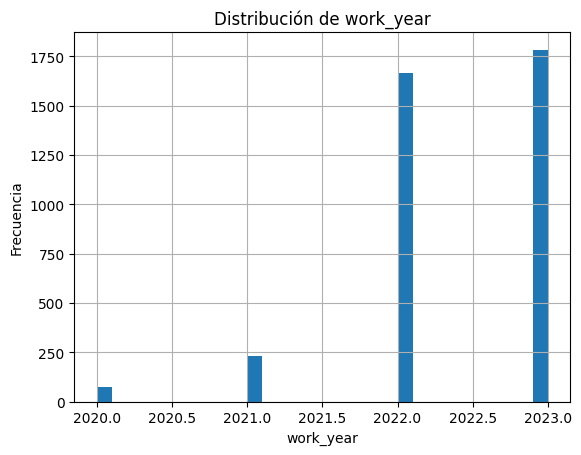

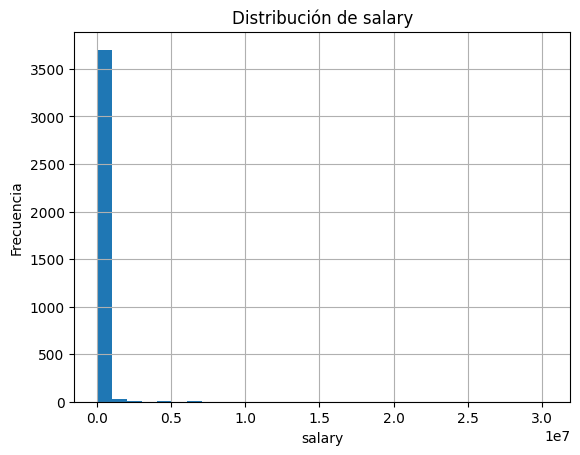

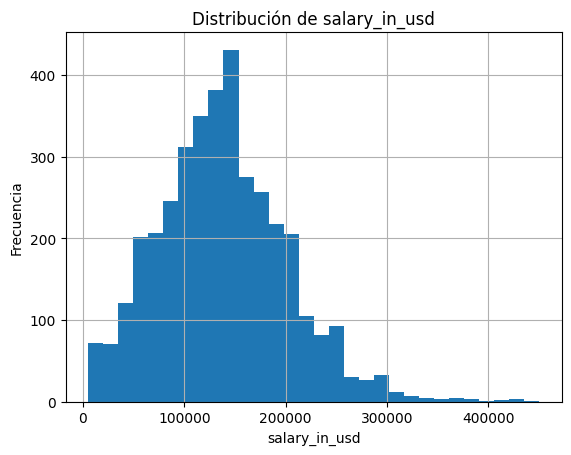

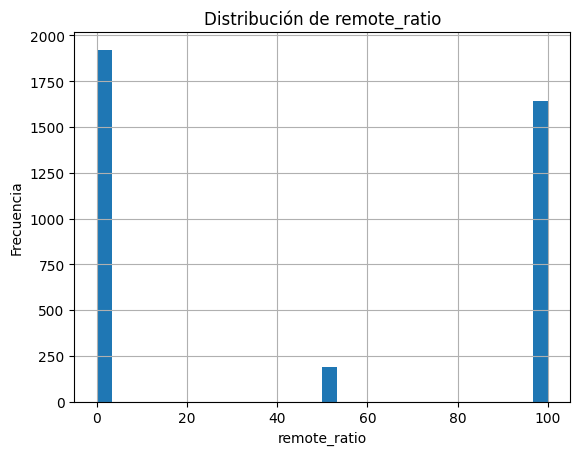

In [98]:
# Histogramas de variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

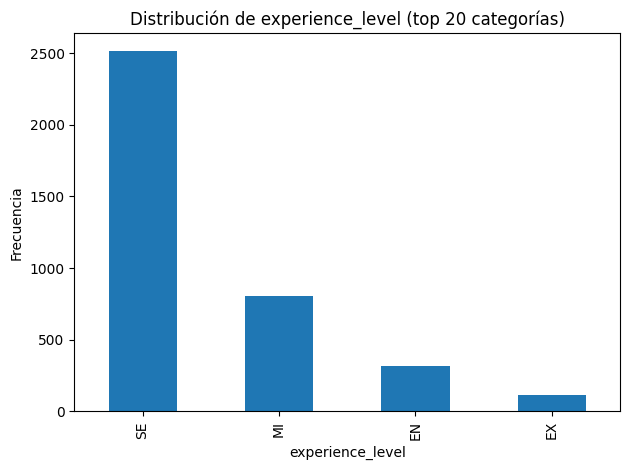

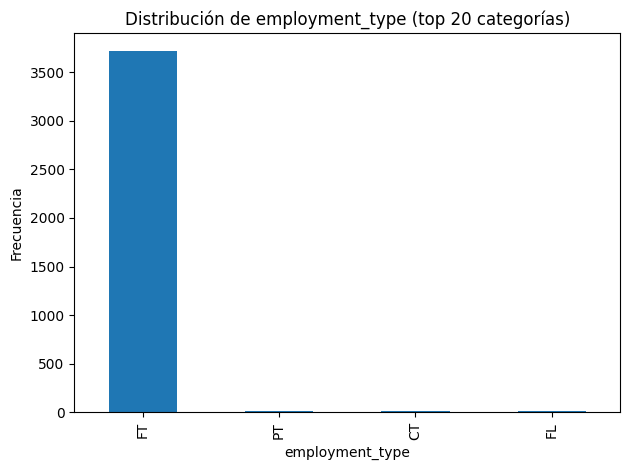

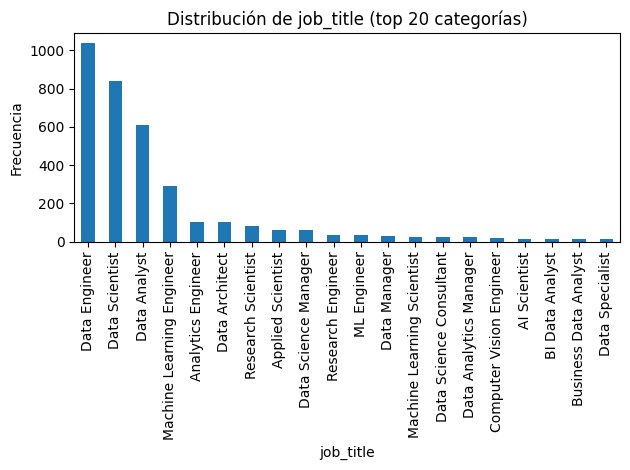

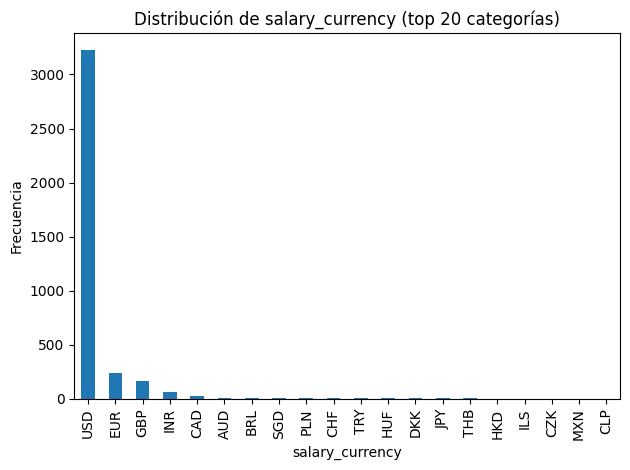

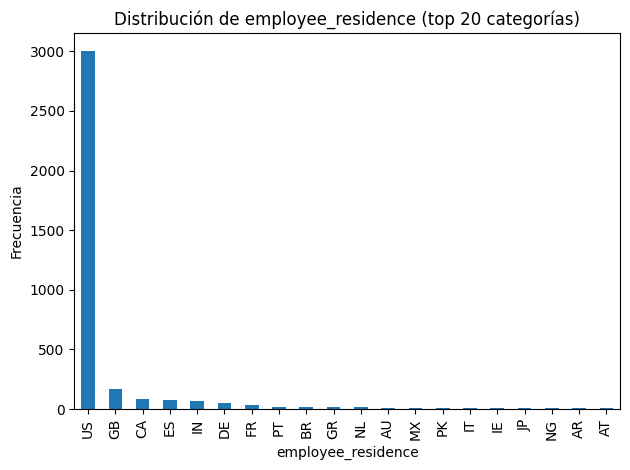

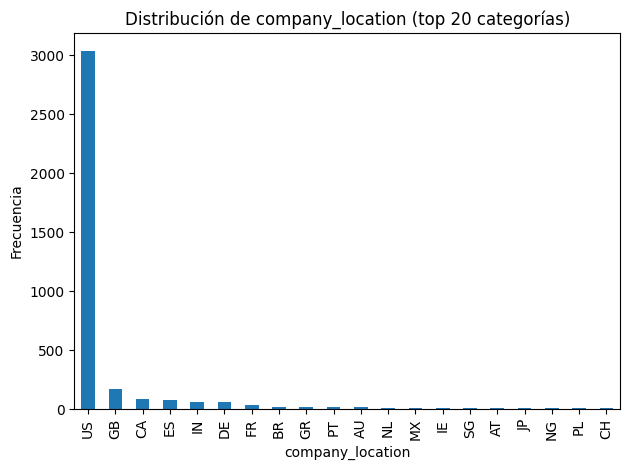

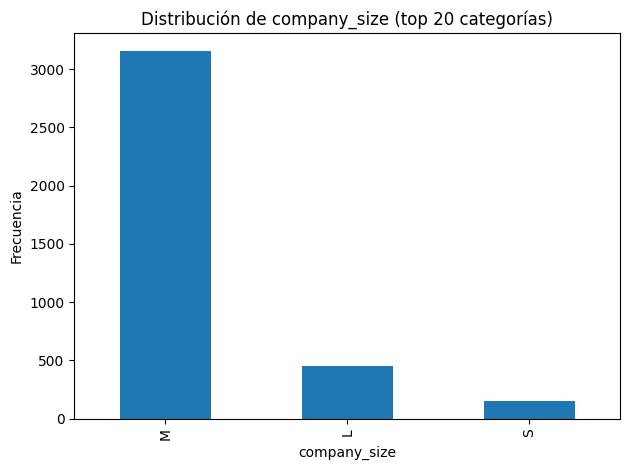

In [99]:
# Diagramas de barras para variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    plt.figure()
    df[col].value_counts().head(20).plot(kind='bar')
    plt.title(f'Distribución de {col} (top 20 categorías)')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

## Análisis bivariante y correlaciones

Nos enfocamos en la relación entre `salary_in_usd` y el resto de variables, buscando identificar patrones y posibles variables con mayor poder explicativo.

In [100]:
# Correlación entre variables numéricas (incluyendo salary_in_usd)
corr_matrix = df[numeric_cols].corr()
corr_matrix['salary_in_usd'].sort_values(ascending=False)

salary_in_usd    1.000000
work_year        0.228290
salary          -0.023676
remote_ratio    -0.064171
Name: salary_in_usd, dtype: float64

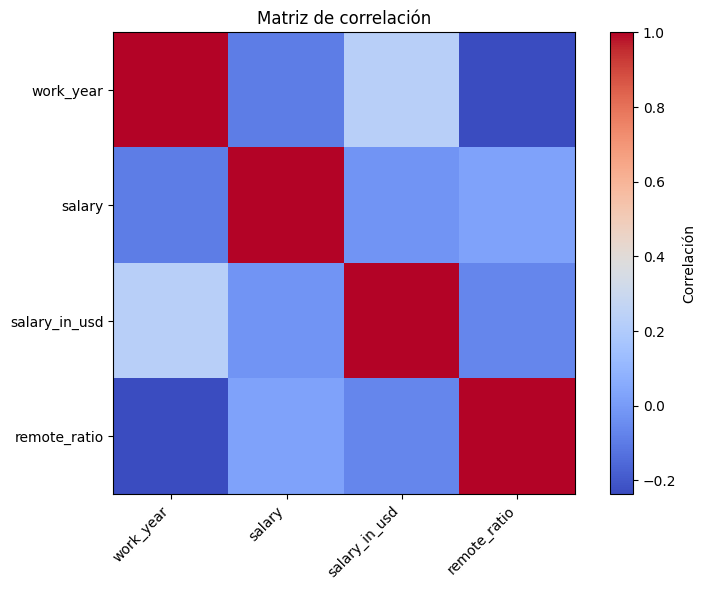

In [101]:
# Mapa de calor de correlaciones numéricas
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar(label='Correlación')
plt.title('Matriz de correlación')
plt.tight_layout()
plt.show()



In [102]:
# Salario promedio por nivel de experiencia
df.groupby('experience_level')['salary_in_usd'].mean().sort_values(ascending=False)

experience_level
EX    194930.929825
SE    153051.071542
MI    104525.939130
EN     78546.284375
Name: salary_in_usd, dtype: float64

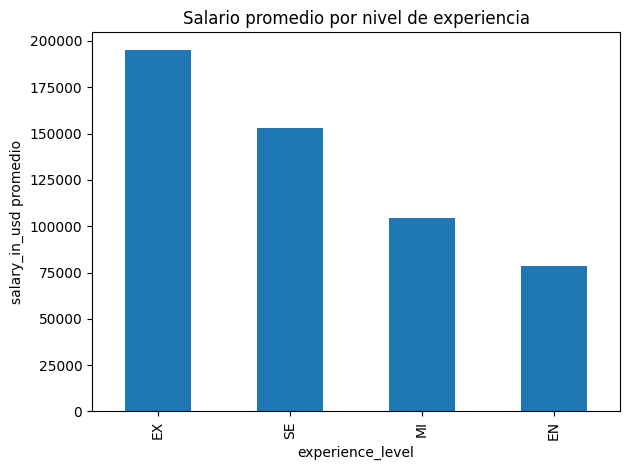

In [103]:
# Gráfico salario promedio por nivel de experiencia
exp_salary = df.groupby('experience_level')['salary_in_usd'].mean().sort_values(ascending=False)
plt.figure()
exp_salary.plot(kind='bar')
plt.title('Salario promedio por nivel de experiencia')
plt.xlabel('experience_level')
plt.ylabel('salary_in_usd promedio')
plt.tight_layout()
plt.show()

In [104]:
# Salario promedio por tamaño de empresa
comp_salary = df.groupby('company_size')['salary_in_usd'].mean().sort_values(ascending=False)
comp_salary

company_size
M    143130.548367
L    118300.982379
S     78226.682432
Name: salary_in_usd, dtype: float64

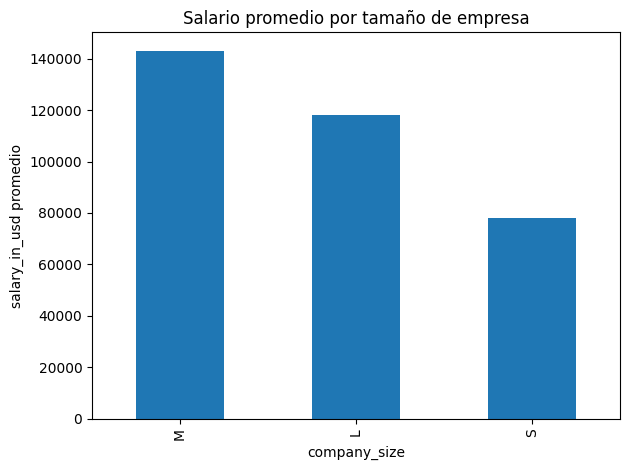

In [105]:
plt.figure()
comp_salary.plot(kind='bar')
plt.title('Salario promedio por tamaño de empresa')
plt.xlabel('company_size')
plt.ylabel('salary_in_usd promedio')
plt.tight_layout()
plt.show()

In [106]:
# Salario promedio por porcentaje de trabajo remoto
remote_salary = df.groupby('remote_ratio')['salary_in_usd'].mean().sort_values(ascending=False)
remote_salary

remote_ratio
0      144316.202288
100    136481.452830
50      78400.687831
Name: salary_in_usd, dtype: float64

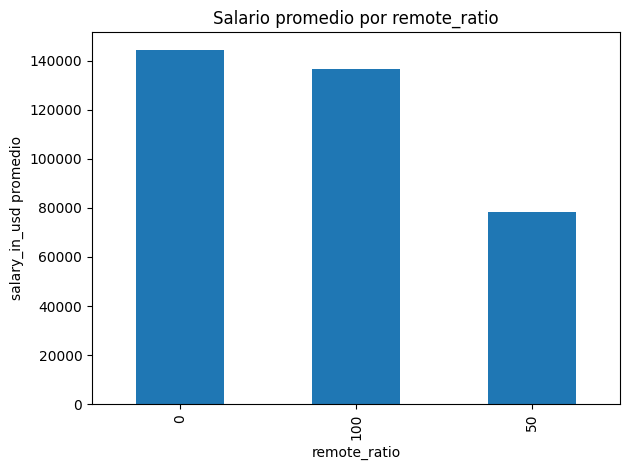

In [107]:
plt.figure()
remote_salary.plot(kind='bar')
plt.title('Salario promedio por remote_ratio')
plt.xlabel('remote_ratio')
plt.ylabel('salary_in_usd promedio')
plt.tight_layout()
plt.show()

## Preparación de datos para modelado

En esta sección se construye un pipeline de preprocesamiento para **regresión** con variable objetivo `salary_in_usd`. El pipeline incluye:

- Separación en variables predictoras `X` y objetivo `y`.
- División en conjuntos de entrenamiento y prueba.
- Imputación de nulos (mediana para numéricas, moda para categóricas).
- Escalado de variables numéricas.
- Codificación *one-hot* de variables categóricas.

El resultado es un `preprocessor` que puede ser encadenado con cualquier modelo de `scikit-learn` (por ejemplo, `RandomForestRegressor`, `XGBRegressor`, `LinearRegression`, etc.).

In [108]:
# Definir variable objetivo y features
target = 'salary_in_usd'

# Eliminamos salary y salary_currency porque su información ya está contenida en salary_in_usd
X = df.drop(columns=['salary_in_usd', 'salary', 'salary_currency', 
                    'employee_residence', 'company_location', 
                    'work_year','job_title'])
y = df[target]

X.head()

,experience_level,employment_type,remote_ratio,company_size
0,SE,FT,100,L
1,MI,CT,100,S
2,MI,CT,100,S
3,SE,FT,100,M
4,SE,FT,100,M


In [109]:
# Separar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_features, categorical_features

(['remote_ratio'], ['experience_level', 'employment_type', 'company_size'])

In [110]:
# División train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((3004, 4), (751, 4))

In [111]:
from sklearn.pipeline import Pipeline

# Pipelines de preprocesamiento para numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [112]:
# Ajustar el preprocesador y transformar los datos
preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape
feature_names = preprocessor.get_feature_names_out()

## Creación final de datasets X e y

En esta sección se dejan **explícitamente creados** los datasets finales `X` e `y`,
tanto en su versión **cruda** como en su versión **procesada**, listos para ser usados
en modelos de machine learning o exportados a otros notebooks/scripts.


In [113]:
# Dataset final de variables independientes (crudo)
X_final = X.copy()

# Dataset final de variable objetivo
y_final = y.copy()

print('X_final shape:', X_final.shape)
print('y_final shape:', y_final.shape)

X_final.head()

X_final shape: (3755, 4)
y_final shape: (3755,)


,experience_level,employment_type,remote_ratio,company_size
0,SE,FT,100,L
1,MI,CT,100,S
2,MI,CT,100,S
3,SE,FT,100,M
4,SE,FT,100,M


In [114]:
# Versiones procesadas (numéricas) listas para modelos

X_train_final = X_train_processed
X_test_final = X_test_processed
y_train_final = y_train
y_test_final = y_test

X_train_final.shape, X_test_final.shape

((3004, 12), (751, 12))

In [117]:
pd.DataFrame(X_train_final,columns=feature_names).to_csv('data/X_train_processed.csv', index=False)
pd.DataFrame(X_test_final,columns=feature_names).to_csv('data/X_test_processed.csv', index=False)
y_train_final.to_csv('data/y_train.csv', index=False)
y_test_final.to_csv('data/y_test.csv', index=False)